<a href="https://colab.research.google.com/github/woodword-0/ML-Projects/blob/main/Copy_of_Wally_World_CorpARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from math import floor
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA 

from google.colab import drive
drive.mount('/content/gdrive')

np.random.seed(9001)
#WHAT!? 9000!?!?

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


#Load Data

In [ ]:
df=pd.read_csv('gdrive/My Drive/Colab Notebooks/TimeSeries/Walmart_Data/W_Corporate.csv')
df=df.drop(columns=['Unnamed: 0','Weekly_Sales_log','minMax_WeeklySales','minMax_log'])
df=df.rename(columns={'Date':'ds','log_minMax':'ts'})

In [ ]:
df.describe()

,Weekly_Sales,ts
count,1.430000e+02,143.000000
mean,4.306387e+07,0.282736
std,3.532692e+06,0.138834
min,3.684533e+07,0.000000
25%,4.155836e+07,0.222445
50%,4.255290e+07,0.266150
75%,4.395299e+07,0.325974
max,6.329779e+07,1.000000


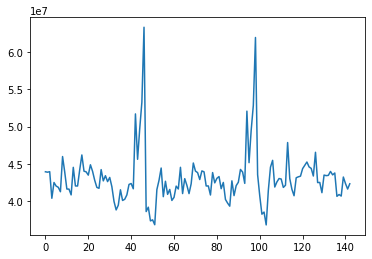

In [ ]:
plt.figure()
plt.plot(df.Weekly_Sales)

#Begin Decomposition

In [ ]:
def plot_decomposition(df,ts,trend,seasonal,residual):
  f,((ax1,ax2),(ax3,ax4))=plt.subplots(2,2,figsize=(15,5), sharex=True)

  ax1.plot(df[ts],label="Original")
  ax1.legend(loc='best')
  ax1.tick_params(axis='x', rotation=45)

  ax2.plot(df[trend],label="Trend")
  ax2.legend(loc='best')
  ax2.tick_params(axis='x', rotation=45)

  ax3.plot(df[seasonal],label="Seasonal")
  ax3.legend(loc='best')
  ax3.tick_params(axis='x', rotation=45)

  ax4.plot(df[residual],label="Residuals")
  ax4.legend(loc='best')
  ax4.tick_params(axis='x', rotation=45)
  plt.tight_layout

  plt.show()

In [ ]:
decomposition=seasonal_decompose(df['ts'],freq=52, extrapolate_trend=1)

In [ ]:
New_df=df.copy()
New_df.loc[:,'trend']=decomposition.trend
New_df.loc[:,'seasonal']=decomposition.seasonal
New_df.loc[:,'residuals']=decomposition.resid

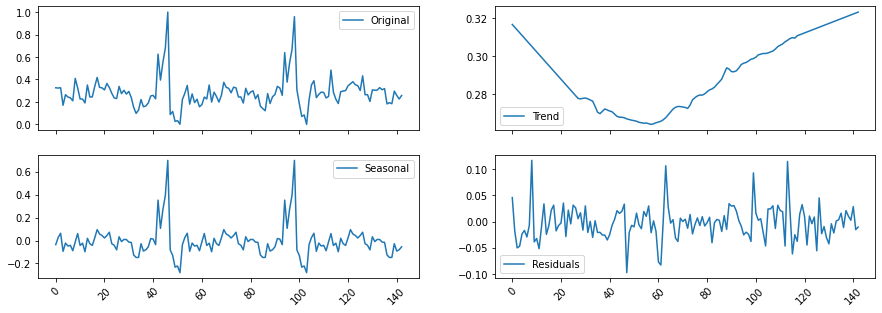

In [ ]:
plot_decomposition(New_df,ts='ts',trend='trend',seasonal='seasonal',residual='residuals')

#Stationality Testing

In [ ]:
def test_stationarity(df,ts):
  #determine Rolling Statistics
  rolling_mean=df[ts].rolling(window=12,center=False).mean()
  rolling_std=df[ts].rolling(window=12,center=False).std()

  orig=plt.plot(df[ts],color='blue',label='Original')
  mean=plt.plot(rolling_mean,color='red',label='Rolling Mean')
  std=plt.plot(rolling_std,color='black',label='Rolling Std')

  plt.legend(loc='best')
  plt.title('Rolling Mean and Standard Deviation for (%s)' %ts)
  plt.xticks(rotation=45)
  plt.show(block=False)
  plt.close

  #Dickey_Fuller Test: Null Hypothesis(H_0): time series is not stationary
  #Alternative Hypthesis(H_1): time series is stationary

  print('Results:')
  dftest=adfuller(df[ts],autolag='AIC')
  dfoutput=pd.Series(dftest[0:4],index=['Test Statistic','p-value','# Lags Used','Number of Observations'])

  for key,value in dftest[4].items():
    dfoutput['Critical Value(%s)' %key]=value 

  print(dfoutput)

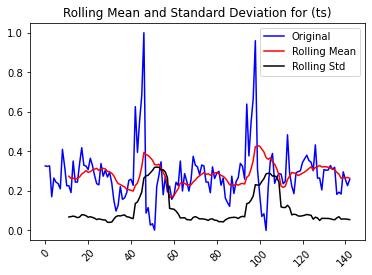

Results:
Test Statistic             -4.932634
p-value                     0.000030
# Lags Used                 9.000000
Number of Observations    133.000000
Critical Value(1%)         -3.480500
Critical Value(5%)         -2.883528
Critical Value(10%)        -2.578496
dtype: float64


In [ ]:
test_stationarity(df=df,ts='ts')

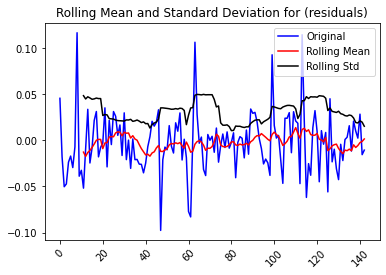

Results:
Test Statistic           -1.113018e+01
p-value                   3.297107e-20
# Lags Used               0.000000e+00
Number of Observations    1.420000e+02
Critical Value(1%)       -3.477262e+00
Critical Value(5%)       -2.882118e+00
Critical Value(10%)      -2.577743e+00
dtype: float64


In [ ]:
test_stationarity(df=New_df,ts='residuals')

#Running ARIMA

##Train, Validation, Test Split

In [ ]:
trainInd=floor(len(df)*.8)
valInd=floor(len(df)*.9)
train=df.loc[:trainInd,:]
val=df['ds'][trainInd:valInd]
val=val.to_frame()
test=df['ds'][valInd:]
test=test.to_frame()

In [ ]:
val.head()

,ds
114,2012-04-13
115,2012-04-20
116,2012-04-27
117,2012-05-04
118,2012-05-11


In [ ]:
def run_Arima(df,ts,p,d,q):
  model=ARIMA(df[ts],order=(p,d,q))
  results_arima=model.fit(disp=-1)

  len_results=len(results_arima.fittedvalues)
  ts_modified=df[ts][-len_results:]

  rss=sum((results_arima.fittedvalues-ts_modified)**2)
  rmse=np.sqrt(rss/len(df[ts]))
  print('rmse:',rmse)
  plt.figure()
  plt.plot(df[ts])
  plt.plot(results_arima.fittedvalues,color='red')

  plt.show()

  return results_arima

rmse: 0.11311060543981291


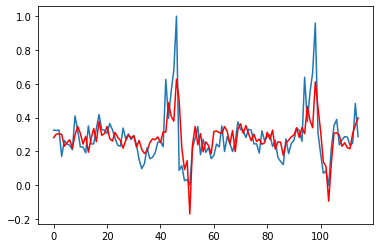

In [ ]:
model_Ar=run_Arima(df=train,ts='ts',p=15,d=0,q=0)

In [ ]:
pickle.dump(model_Ar,open(r'gdrive/My Drive/Colab Notebooks/TimeSeries/Walmart_Notebooks/W_Corp_ARIMA.sav','wb'))